In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [9]:
# Importing tensorflow
np.random.seed(42)
#import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
                              intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1
                              )

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM , BatchNormalization
from keras.regularizers import L1L2
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns

# To be able to save images on server
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
from datetime import datetime

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [15]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [16]:
def plot_train_cv_loss(trained_model, epochs, colors=['g']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'g', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## Trail 4

In [20]:
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [21]:
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model Summary: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 14,022
Tr

In [22]:
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [25]:
start = datetime.now()

# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=n_epochs)

print("\n Time Taken: ",datetime.now() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.5433 - accuracy: 0.6223 - val_loss: 1.1721 - val_accuracy: 0.6508
Epoch 2/30
7352/7352 [==============================] - 57s 8ms/step - loss: 0.8973 - accuracy: 0.7242 - val_loss: 0.7987 - val_accuracy: 0.7299
Epoch 3/30
7352/7352 [==============================] - 59s 8ms/step - loss: 0.6262 - accuracy: 0.8016 - val_loss: 0.5663 - val_accuracy: 0.7964
Epoch 4/30
7352/7352 [==============================] - 56s 8ms/step - loss: 0.4606 - accuracy: 0.8565 - val_loss: 0.3072 - val_accuracy: 0.8989
Epoch 5/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.3512 - accuracy: 0.8916 - val_loss: 0.2956 - val_accuracy: 0.8968
Epoch 6/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.3429 - accuracy: 0.8951 - val_loss: 0.4878 - val_accu

In [26]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      417        72        0                   0   
STANDING                 0      108       424        0                   0   
WALKING                  0        0         0      495                   1   
WALKING_DOWNSTAIRS       0        0         0       12                 407   
WALKING_UPSTAIRS         0        0         0       48                   2   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 421  


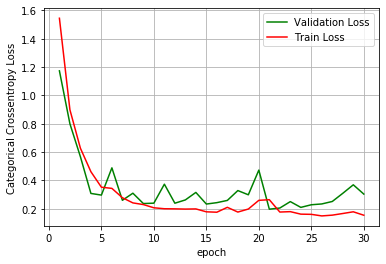

In [28]:
plot_train_cv_loss(trained_model, n_epochs)

In [27]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 3s 901us/step


[0.3027004264884881, 0.9165253043174744]

## Observation

In [ ]:
## this model is works well and we still need to improve the score 


## Trail 5

In [23]:
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [24]:
model1 = Sequential()
model1.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model1.add(BatchNormalization())
model1.add(Dropout(0.50))
model1.add(LSTM(32))
model1.add(Dropout(0.50))
model1.add(Dense(n_classes, activation='relu'))
print("Model Summary: ")
model1.summary()

Model Summary: 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 31,814
Trainable params: 31,686
Non-trainable params: 128
________________________________

In [25]:
model1.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [26]:
start = datetime.now()

# Training the model
trained_model  = model1.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=n_epochs)

print("\n Time Taken: ",datetime.now() - start)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 75s 10ms/step - loss: nan - accuracy: 0.1665 - val_loss: nan - val_accuracy: 0.1683
Epoch 2/30
7352/7352 [==============================] - 75s 10ms/step - loss: nan - accuracy: 0.1668 - val_loss: nan - val_accuracy: 0.1683
Epoch 3/30
7352/7352 [==============================] - 71s 10ms/step - loss: nan - accuracy: 0.1668 - val_loss: nan - val_accuracy: 0.1683
Epoch 4/30
7352/7352 [==============================] - 69s 9ms/step - loss: nan - accuracy: 0.1668 - val_loss: nan - val_accuracy: 0.1683
Epoch 5/30
7352/7352 [==============================] - 101s 14ms/step - loss: nan - accuracy: 0.1668 - val_loss: nan - val_accuracy: 0.1683
Epoch 6/30
7352/7352 [==============================] - 73s 10ms/step - loss: nan - accuracy: 0.1668 - val_loss: nan - val_accuracy: 0.1683
Epoch 7/30
7352/7352 [==============================] - 66s 9ms/step - loss: nan - accuracy: 0.1668 - val_loss: 

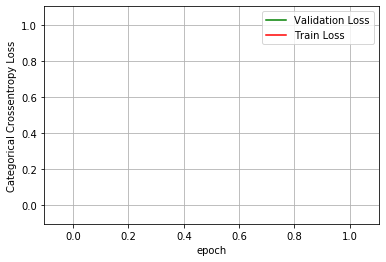

In [27]:
plot_train_cv_loss(trained_model, n_epochs)

In [28]:
# Confusion Matrix
print(confusion_matrix(Y_test, model1.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [29]:
score1 = model1.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [30]:
score1

[nan, 0.16830675303936005]

## Observation

In [2]:
# with the relu activation layer the reults are gone worse
#the test accuracy is 16.83 % 
# the model not even calculated the val_loss 
# here i can conclude that the model with relu activtion is not best for the this case 

## Trail 6

In [17]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [18]:
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
model2.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

In [20]:
model2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.2305 - accuracy: 0.4793 - val_loss: 1.1514 - val_accuracy: 0.4740
Epoch 2/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.9823 - accuracy: 0.5838 - val_loss: 1.1050 - val_accuracy: 0.5331
Epoch 3/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.9200 - accuracy: 0.5958 - val_loss: 0.9512 - val_accuracy: 0.5976
Epoch 4/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.1535 - accuracy: 0.4918 - val_loss: 1.2401 - val_accuracy: 0.4194
Epoch 5/30
7352/7352 [==============================] - 28s 4ms/step - loss: 1.0630 - accuracy: 0.5253 - val_loss: 1.2780 - val_accuracy: 0.3919
Epoch 6/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.8715 - accuracy: 0.6221 - val_loss: 0.8885 - val_accu

In [21]:
print(confusion_matrix(Y_test, model2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_UPSTAIRS
True                                                                    
LAYING                 508        0         0       27                 2
SITTING                  0      373        91       27                 0
STANDING                 0       84       418       30                 0
WALKING                  0        0         0      496                 0
WALKING_DOWNSTAIRS       0        0         0      420                 0
WALKING_UPSTAIRS         0        0         1      470                 0


In [22]:
score = model2.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 1s 439us/step


[0.7983509799282875, 0.609093964099884]

## Observation 

In [31]:
# the optimiser adgrad also failed to calculate the better result
# when we obser the confusion matrix 
# my model is unable to decet the walking upstaris
# this model has given the test accurac of 60.909%only